# Advanced Modeling Features 

In this tutorial we will explore some advanced modeling features of epydemix. In particular, we will:

- Define a new transition kind (behavioral)
- Explore time-varying and age-varying parameters
- Explore the use of shorter time steps and resampling

Let's start by importing the necessary libraries.

In [2]:
from epydemix import EpiModel, load_predefined_model
import matplotlib.pyplot as plt
from epydemix.visualization import plot_quantiles
import numpy as np

## 1. Define a new transition kind (behavioral)

New transition kinds can be defined by passing a custom function to the `register_transition_kind` method of the `EpiModel` class. This function takes as input the name of the new transition kind and the function that computes the transition probability for that kind.

For example, we can define a new transition kind called "behavioral" that takes into account the behavior of the population. We will consider the model presented in [Perra et al. (2011)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0023084), where a new behavioral compartment is introduced to account for the fact that individuals can change their behavior over time and that, as result, get infected with a lower probability. More in detail, we will consider the case in which susceptible individuals can transitiom to the behavioral compartment following the rate:

$$r_{S \to S^B} = \beta_B (1 - e^{-\gamma I})$$

where $\beta_B$ and $\gamma$ regulates the behavioral response. We can see that this rate is not a simple mass-action rate, therefore we need to define a new transition kind. For clarity, here we report the scheme of the model:

We need to define the function that computes the transition probability for the new transition kind. This function must take as input the transition rate (string or list of strings), the transition parameters (a dictionary), and the current state of the system (a dictionary).

In [2]:
def compute_behavioral_transition_probability(params, data): 
    """
    Compute the probability of a behavioral transition.

    Args:
        params: The parameters of the transition.
        data: A dictionary containing information about the current state of the system.
            - parameters: The model parameters. This is a dictionary of arrays, where the key is the name of the parameter and the value is a 
                          2D array of shape (n_time_steps, n_groups). The first dimension is the time step, the second is the demographic group.
            - t: The current time step
            - comp_indices: The indices of the compartments. This is a dictionary where the key is the name of the compartment and the 
                            value is the index of the compartment in the system.
            - contact_matrix: The contact matrix
            - pop: The population in different compartments. This is a 2D array of shape (n_compartments, n_groups). The first dimension is 
                   the compartment, the second is the demographic group.
            - pop_sizes: The population sizes. This is a 1D array of shape (n_groups,).
            - dt: The time step size
    """
    beta_B, gamma = data["parameters"][params["rate"][0]][data["t"]], data["parameters"][params["rate"][1]][data["t"]]
    agent_idx = data["comp_indices"][params["agent"]]
    interaction = beta_B * (1 - np.exp(-gamma * np.sum(data["pop"][agent_idx])))
    return 1 - np.exp(-interaction * data["dt"])


Next, we create the model and register the new transition kind.

In [4]:
model = EpiModel(compartments=["S", "SB", "I", "R"], 
                 parameters={"beta": 0.3, 
                             "mu": 0.1, 
                             "r": 0.3,
                             "beta_B": 0.05, 
                             "gamma": 1. / 10000.})

model.register_transition_kind(kind="behavioral", function=compute_behavioral_transition_probability)

model.add_transition(source="S", target="I", params={"rate": "beta", "agent": "I"}, kind="mediated")
model.add_transition(source="SB", target="I", params={"rate": "r*beta", "agent": "I"}, kind="mediated")
model.add_transition(source="S", target="SB", params={"rate": ["beta_B", "gamma"], "agent": "I"}, kind="behavioral")
model.add_transition(source="I", target="R", params={"rate": "mu"}, kind="spontaneous")

We simulate the model and plot the evolution of individuals in the different compartments.

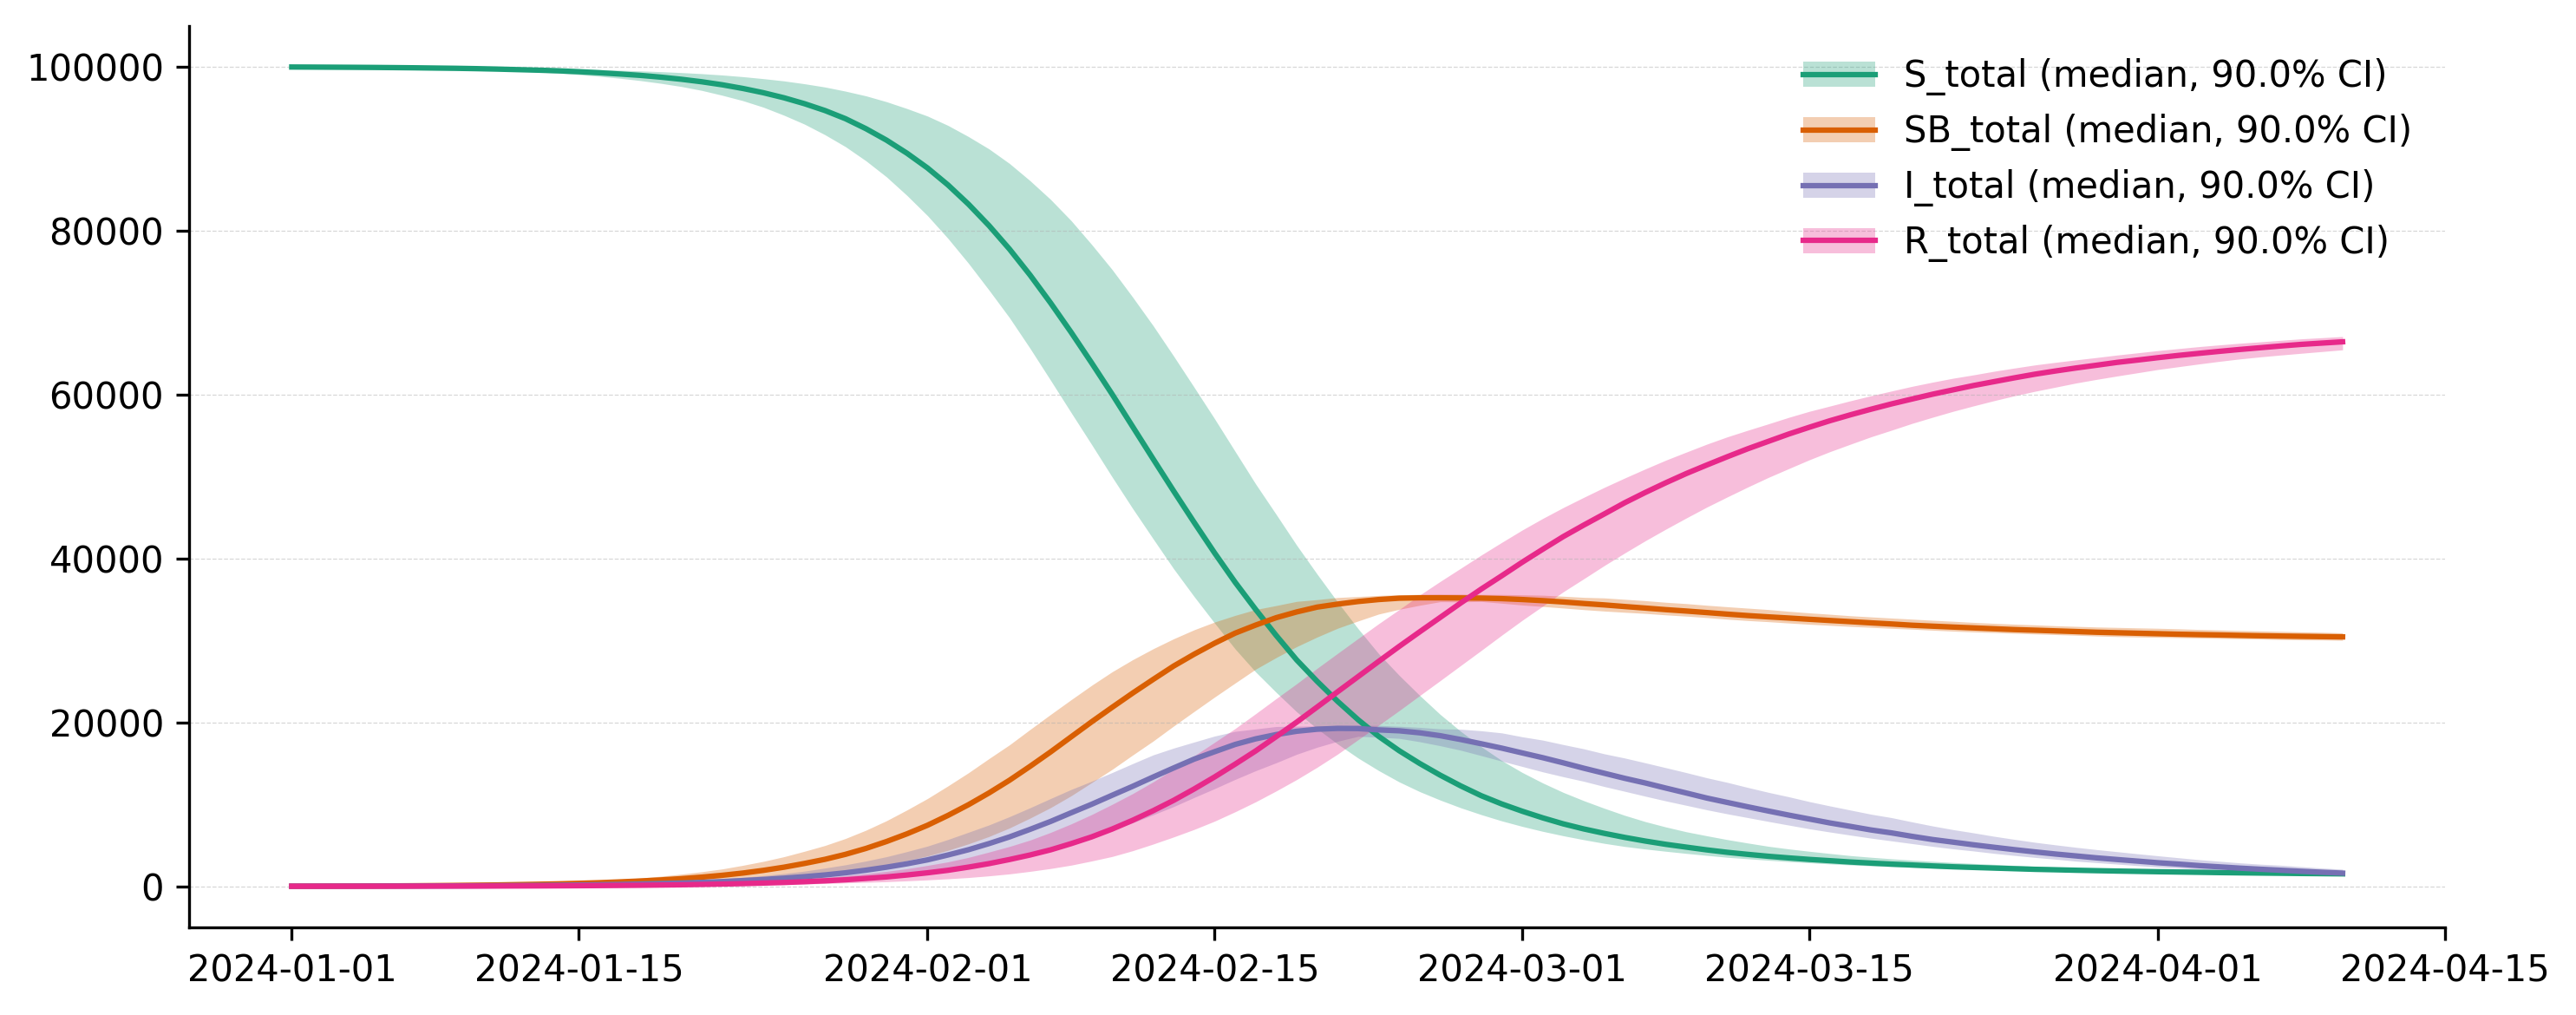

In [5]:
# Initial conditions
initial_conditions = {
    'S': 100000-10,  
    'SB': 0,   
    'I': 10,   
    'R': 0     
}

# running the simulations
results = model.run_simulations(
    start_date="2024-01-01",
    end_date="2024-04-10",
    initial_conditions_dict=initial_conditions
)

# plot
df_quantiles = results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["S_total", "SB_total", "I_total", "R_total"], legend_loc="upper right");

## 2. Time-varying and age-varying parameters

In this section we will explore the use of time-varying and age-varying parameters. This is possible by passing parameters as arrays to the `add_parameter` method. The first dimension of the array is the time step, the second is the age group. In case of time-varying only parameters, arrays of size $(T,)$ are expected, where $T$ is the number of time steps. In case of age-varying only parameters, arrays of size $(1, N)$ are expected, where $N$ is the number of age groups. In case of time-varying and age-varying parameters, arrays of size $(T, N)$ are expected. We define a simple SIR model to work with.


In [6]:
from epydemix.utils import convert_to_2Darray, compute_simulation_dates
from epydemix.population import load_epydemix_population
start_date, end_date = "2024-01-01", "2024-04-10"


# define SIR model
model = load_predefined_model("SIR")

# get simulation dates
simulation_dates = compute_simulation_dates(start_date=start_date, end_date=end_date)

As a first example, we will consider a time-varying transmission rate. We will consider an extreme case with a sinusoidal variation of the transmission rate with a period of 2 weeks.

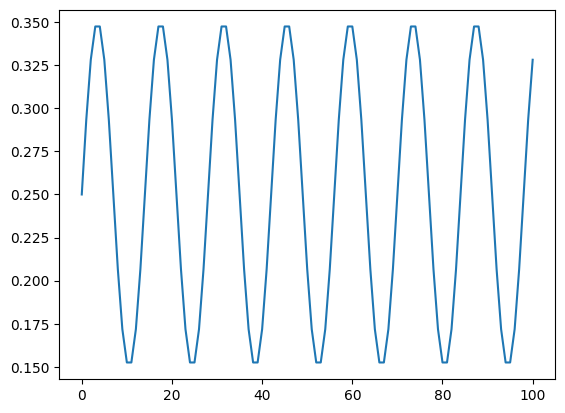

In [7]:
def create_seasonal_parameter(n_points: int, 
                            min_val: float, 
                            max_val: float, 
                            period: int) -> np.ndarray:
    """
    Create a sinusoidal parameter with specified inputs.
    """
    amplitude = (max_val - min_val) / 2
    offset = min_val + amplitude
    t = np.arange(n_points)
    frequency = 2 * np.pi / period
    return amplitude * np.sin(frequency * t) + offset


time_varying_transmission_rate = create_seasonal_parameter(len(simulation_dates), 0.15, 0.35, 14)
plt.plot(time_varying_transmission_rate)

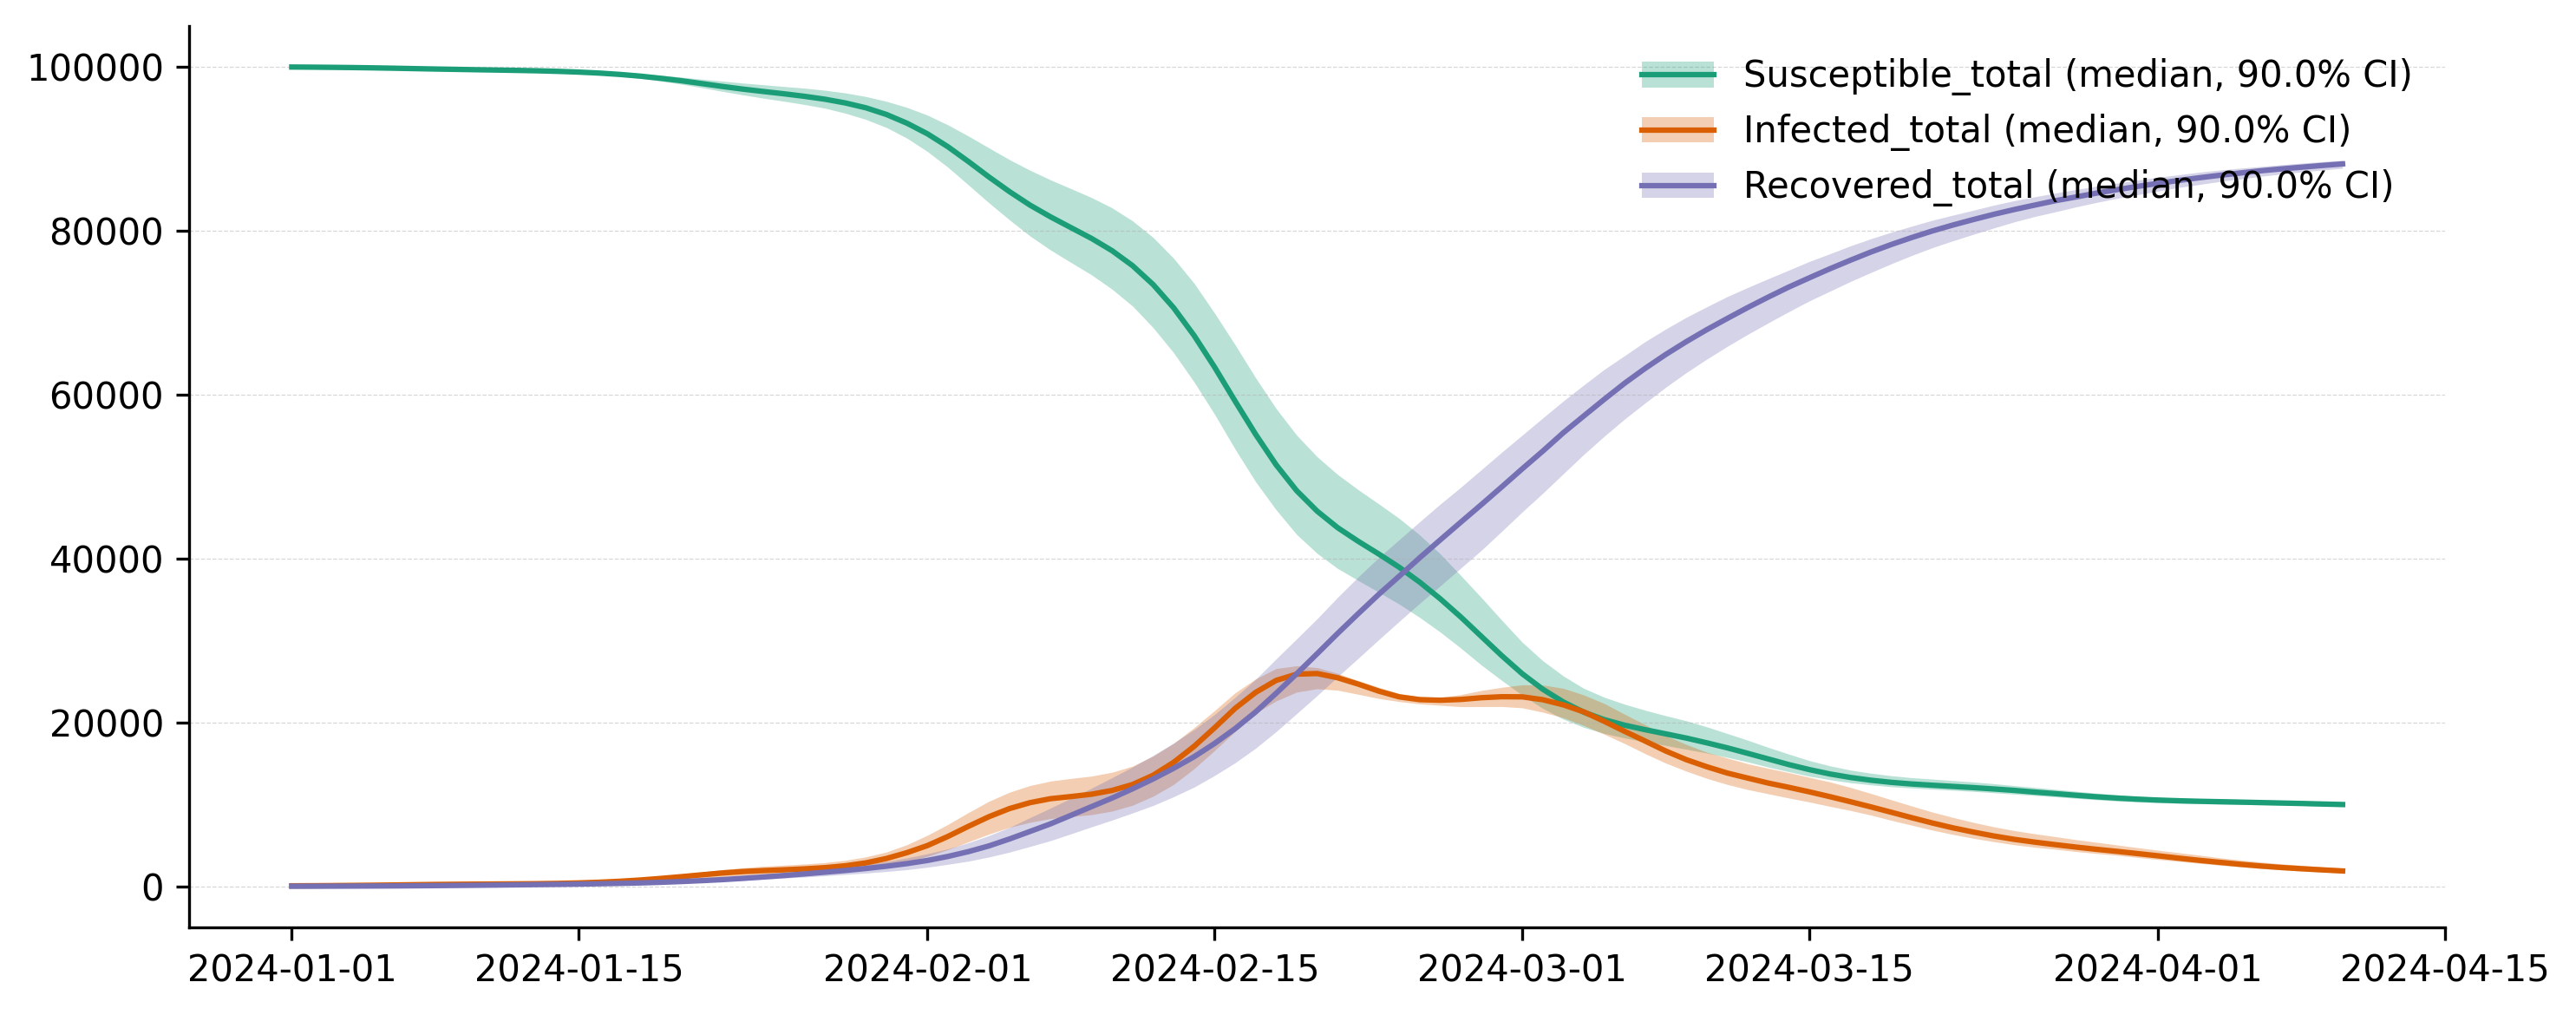

In [8]:
# add time-varying transmission rate to the model
model.add_parameter(name="transmission_rate", value=time_varying_transmission_rate)

# run simulations
results = model.run_simulations(start_date=start_date, end_date=end_date)

# plot results
df_quantiles = results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["Susceptible_total", "Infected_total", "Recovered_total"], legend_loc="upper right");

As a second example we will consider an age-varying transmission rate. We will consider a scenario in which the transmission rate is lower for children. In this case, the age-varying parameter must be a 1D array of size $(1, N)$, where $N$ is the number of age groups, we can use the `convert_to_2Darray` function to convert a 1D array to a 2D array.

In [9]:
# create model and add population
model = load_predefined_model("SIR")
population = load_epydemix_population(population_name="Japan")
model.set_population(population)

print(model)

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, params: {'rate': 'transmission_rate', 'agent': 'Infected'} (kind: mediated)
    Infected -> Recovered, params: {'rate': 'recovery_rate'} (kind: spontaneous)
Parameters: 2
  Model parameters:
    transmission_rate: 0.3
    recovery_rate: 0.1
Population: Japan
  Population size: 124071132 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



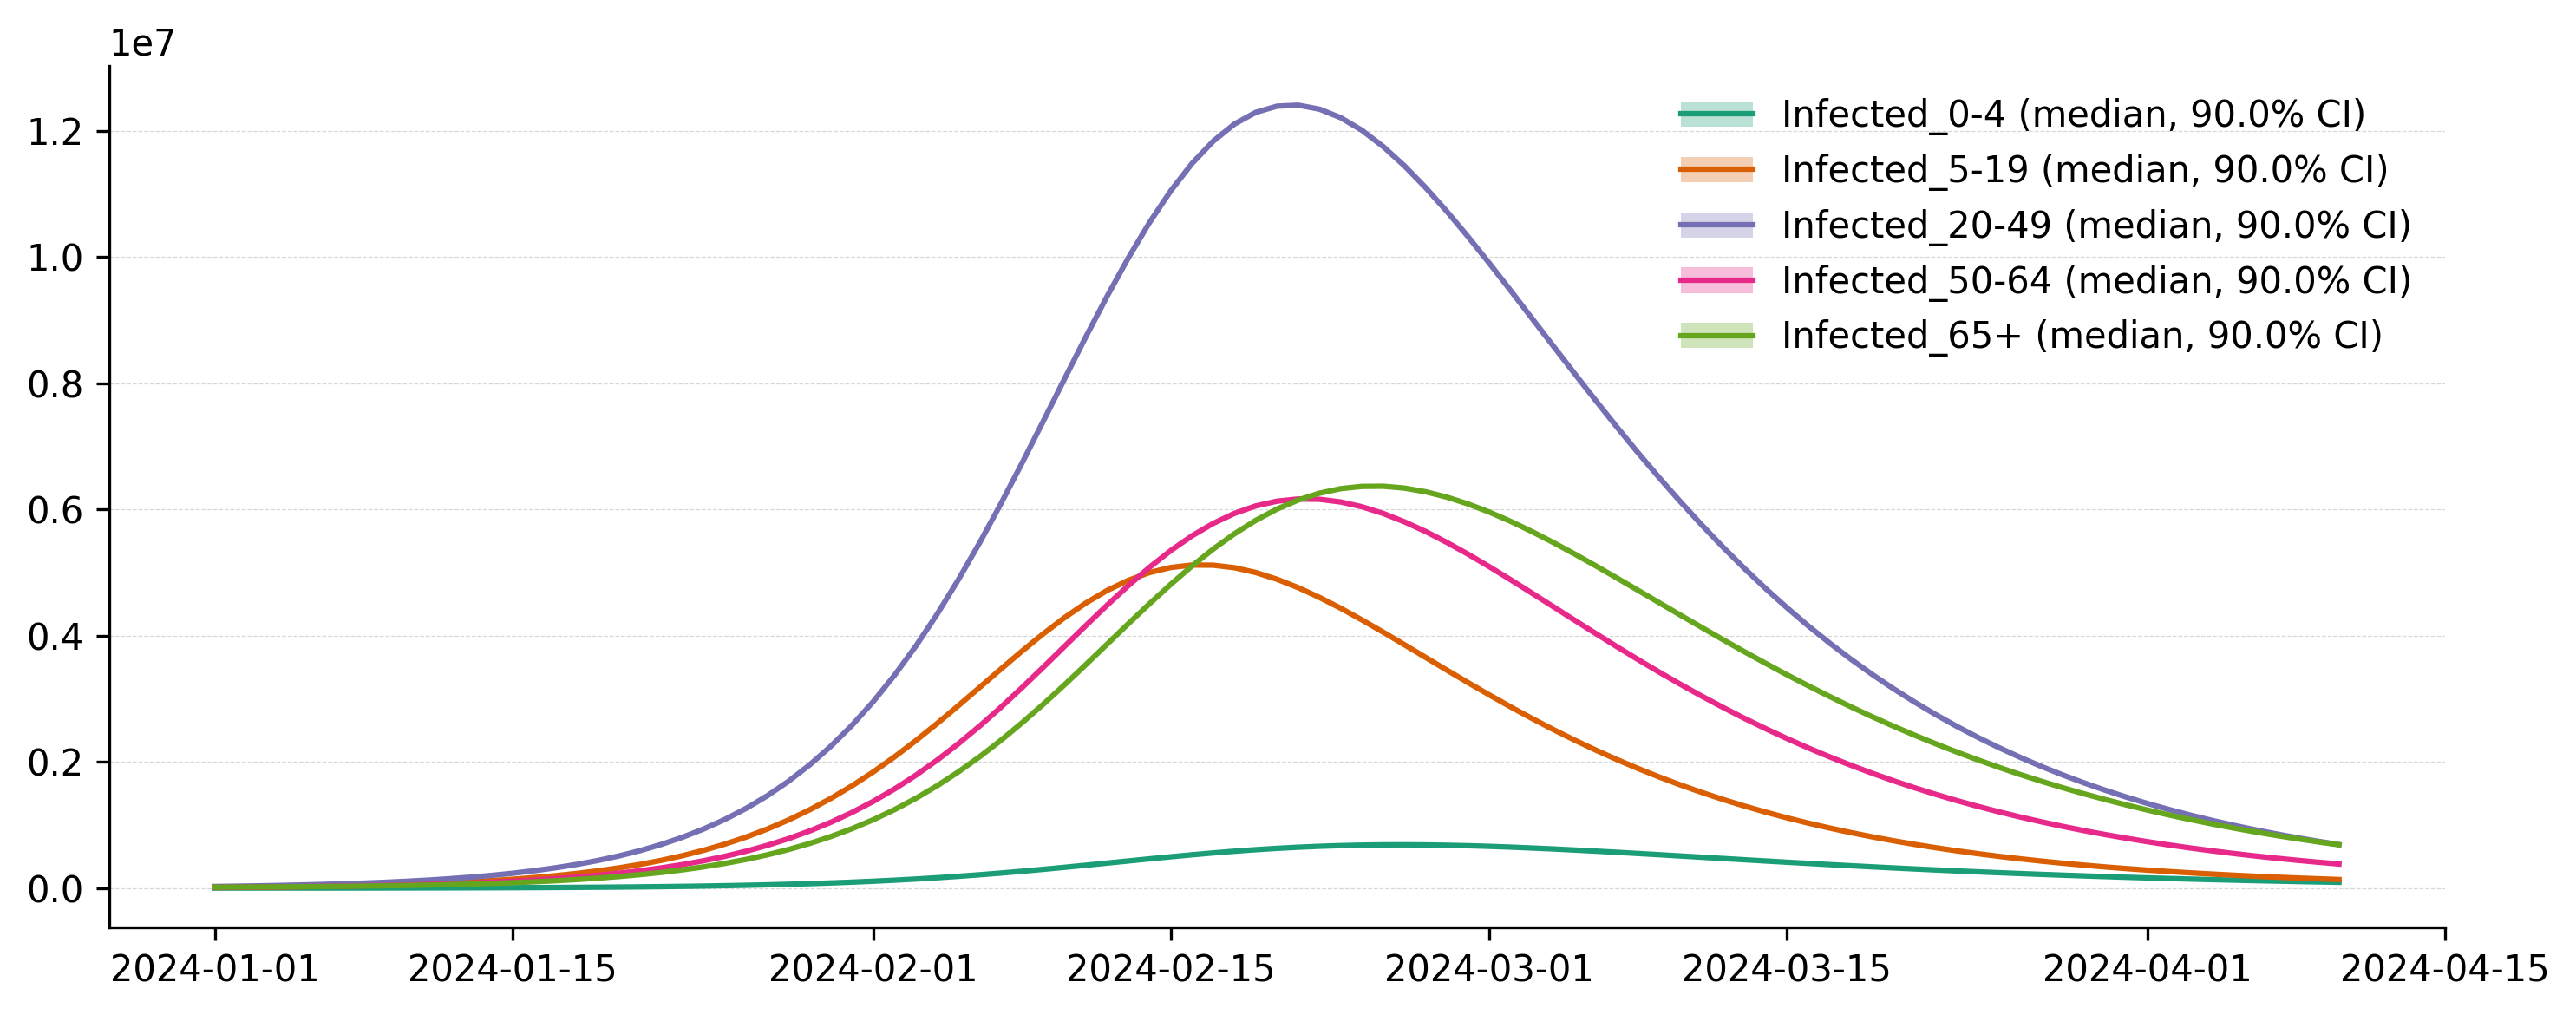

In [10]:
# Populations has 5 age groups: 0-4, 5-19, 20-49, 50-64, 65+
age_varying_transmission_rate = convert_to_2Darray([0.01, 0.02, 0.02, 0.02, 0.02])

# add age-varying transmission rate to the model
model.add_parameter(name="transmission_rate", value=age_varying_transmission_rate)

# run simulations
results = model.run_simulations(start_date=start_date, end_date=end_date)

# plot results
df_quantiles = results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["Infected_0-4", "Infected_5-19", "Infected_20-49", "Infected_50-64", "Infected_65+"], legend_loc="upper right");

Finally, we can consider both time-varying and age-varying parameters. In this case, the parameter must be a 2D array of size $(T, N)$.

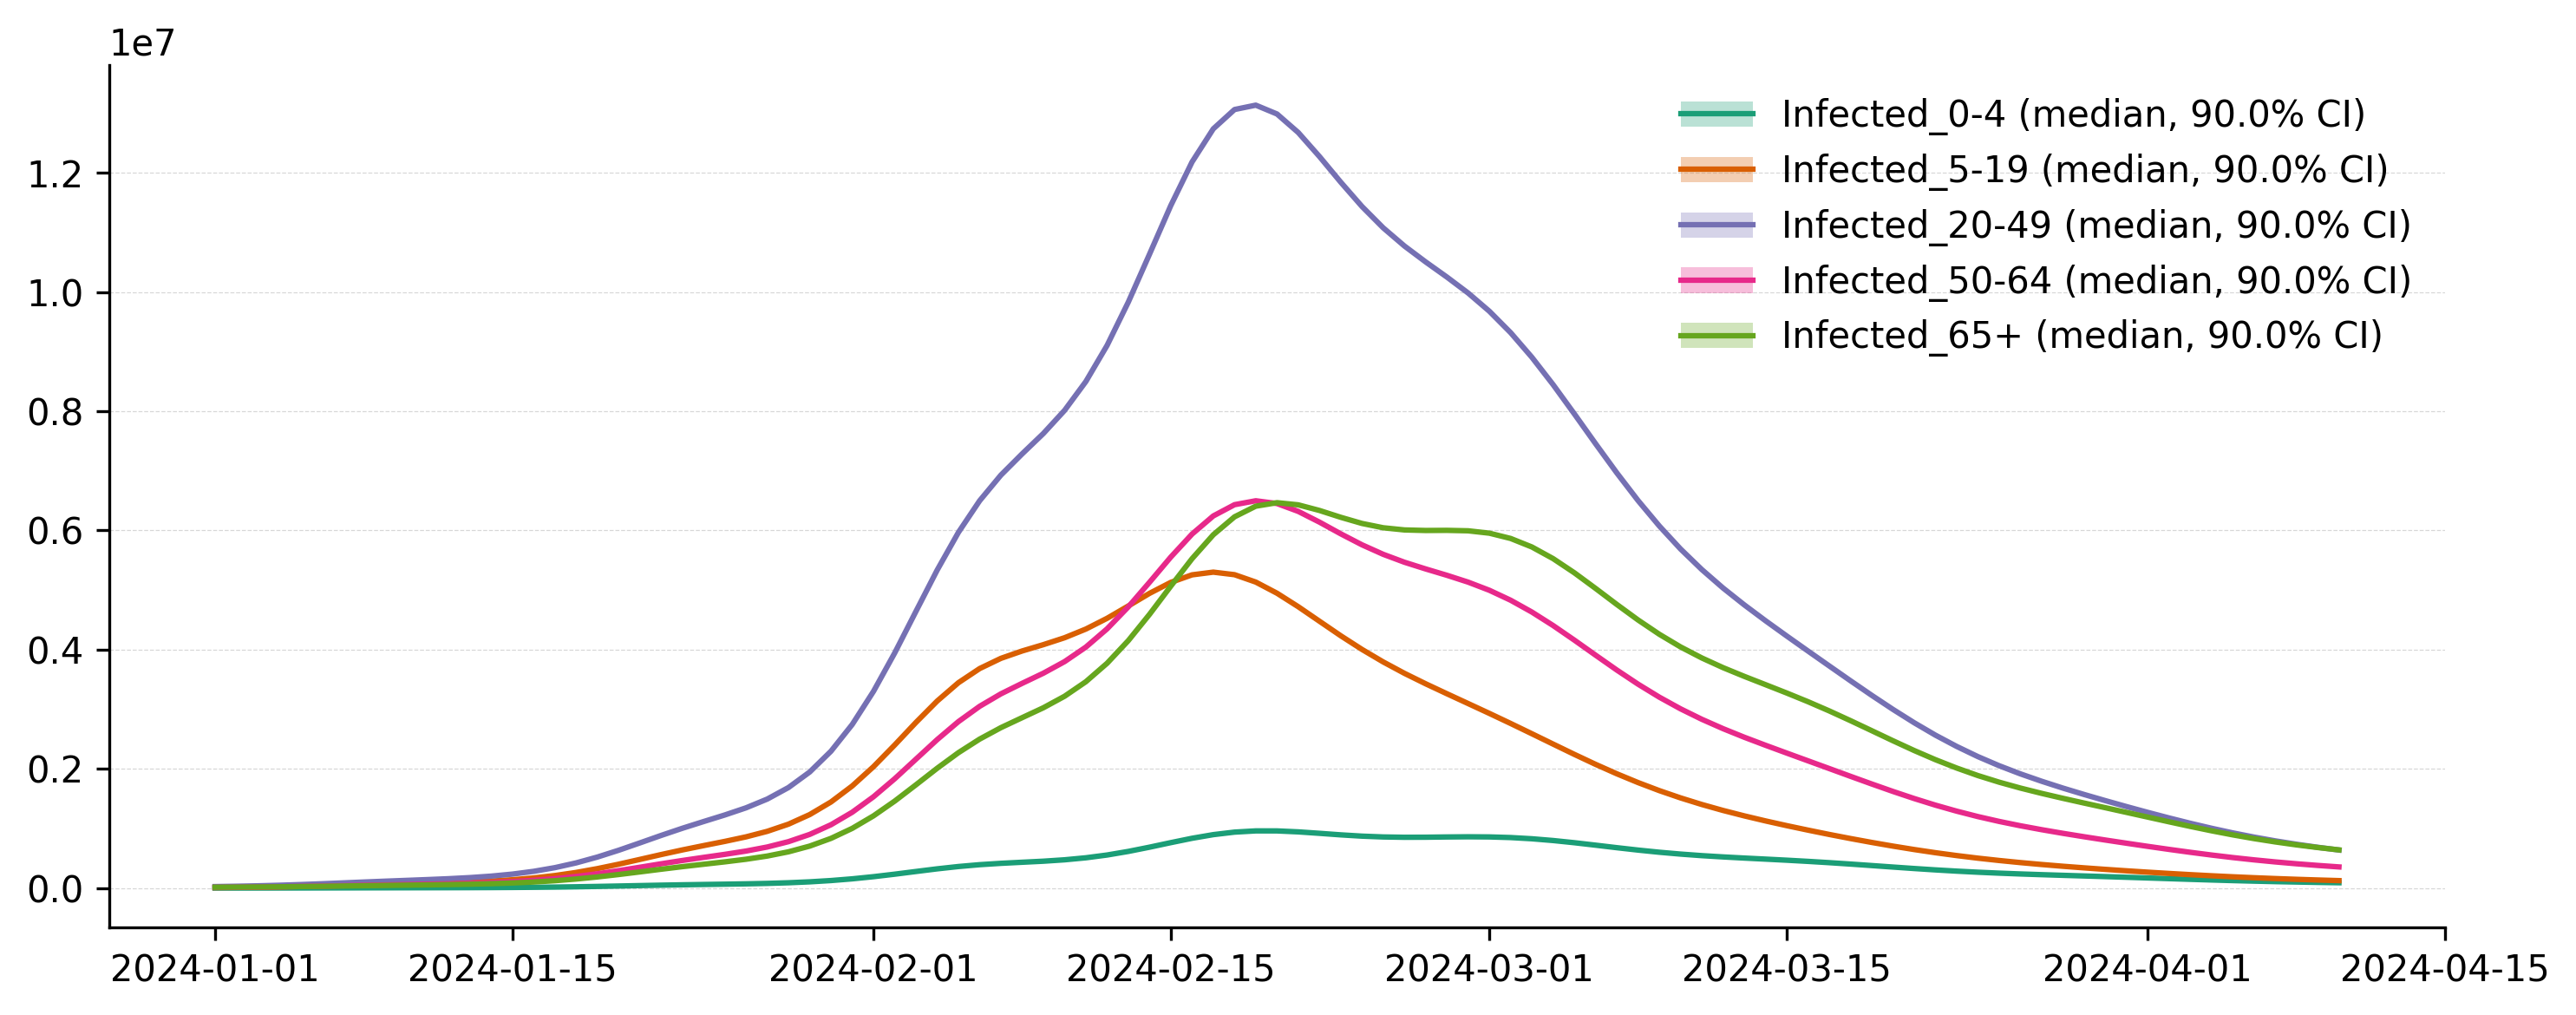

In [11]:
varying_transmission_rate = np.zeros((len(simulation_dates), 5))
for i in range(5):
    if i == 0:
        varying_transmission_rate[:, i] = create_seasonal_parameter(len(simulation_dates), 0.01, 0.02, 14)
    else:
        varying_transmission_rate[:, i] = create_seasonal_parameter(len(simulation_dates), 0.015, 0.025, 14) 

# add time-varying and age-varying transmission rate to the model
model.add_parameter(name="transmission_rate", value=varying_transmission_rate)

# run simulations
results = model.run_simulations(start_date=start_date, end_date=end_date)

# plot results
df_quantiles = results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["Infected_0-4", "Infected_5-19", "Infected_20-49", "Infected_50-64", "Infected_65+"], legend_loc="upper right");

## 3. Shorter time steps size and resampling

By default, epydemix uses a time step size of 1 day. However, it is possible to use shorter time steps by passing the `dt` parameter to the `run_simulations` method. Similarly, it is possible to resample the data at a different frequency by passing the `resample_frequency` parameter to the `run_simulations` method.

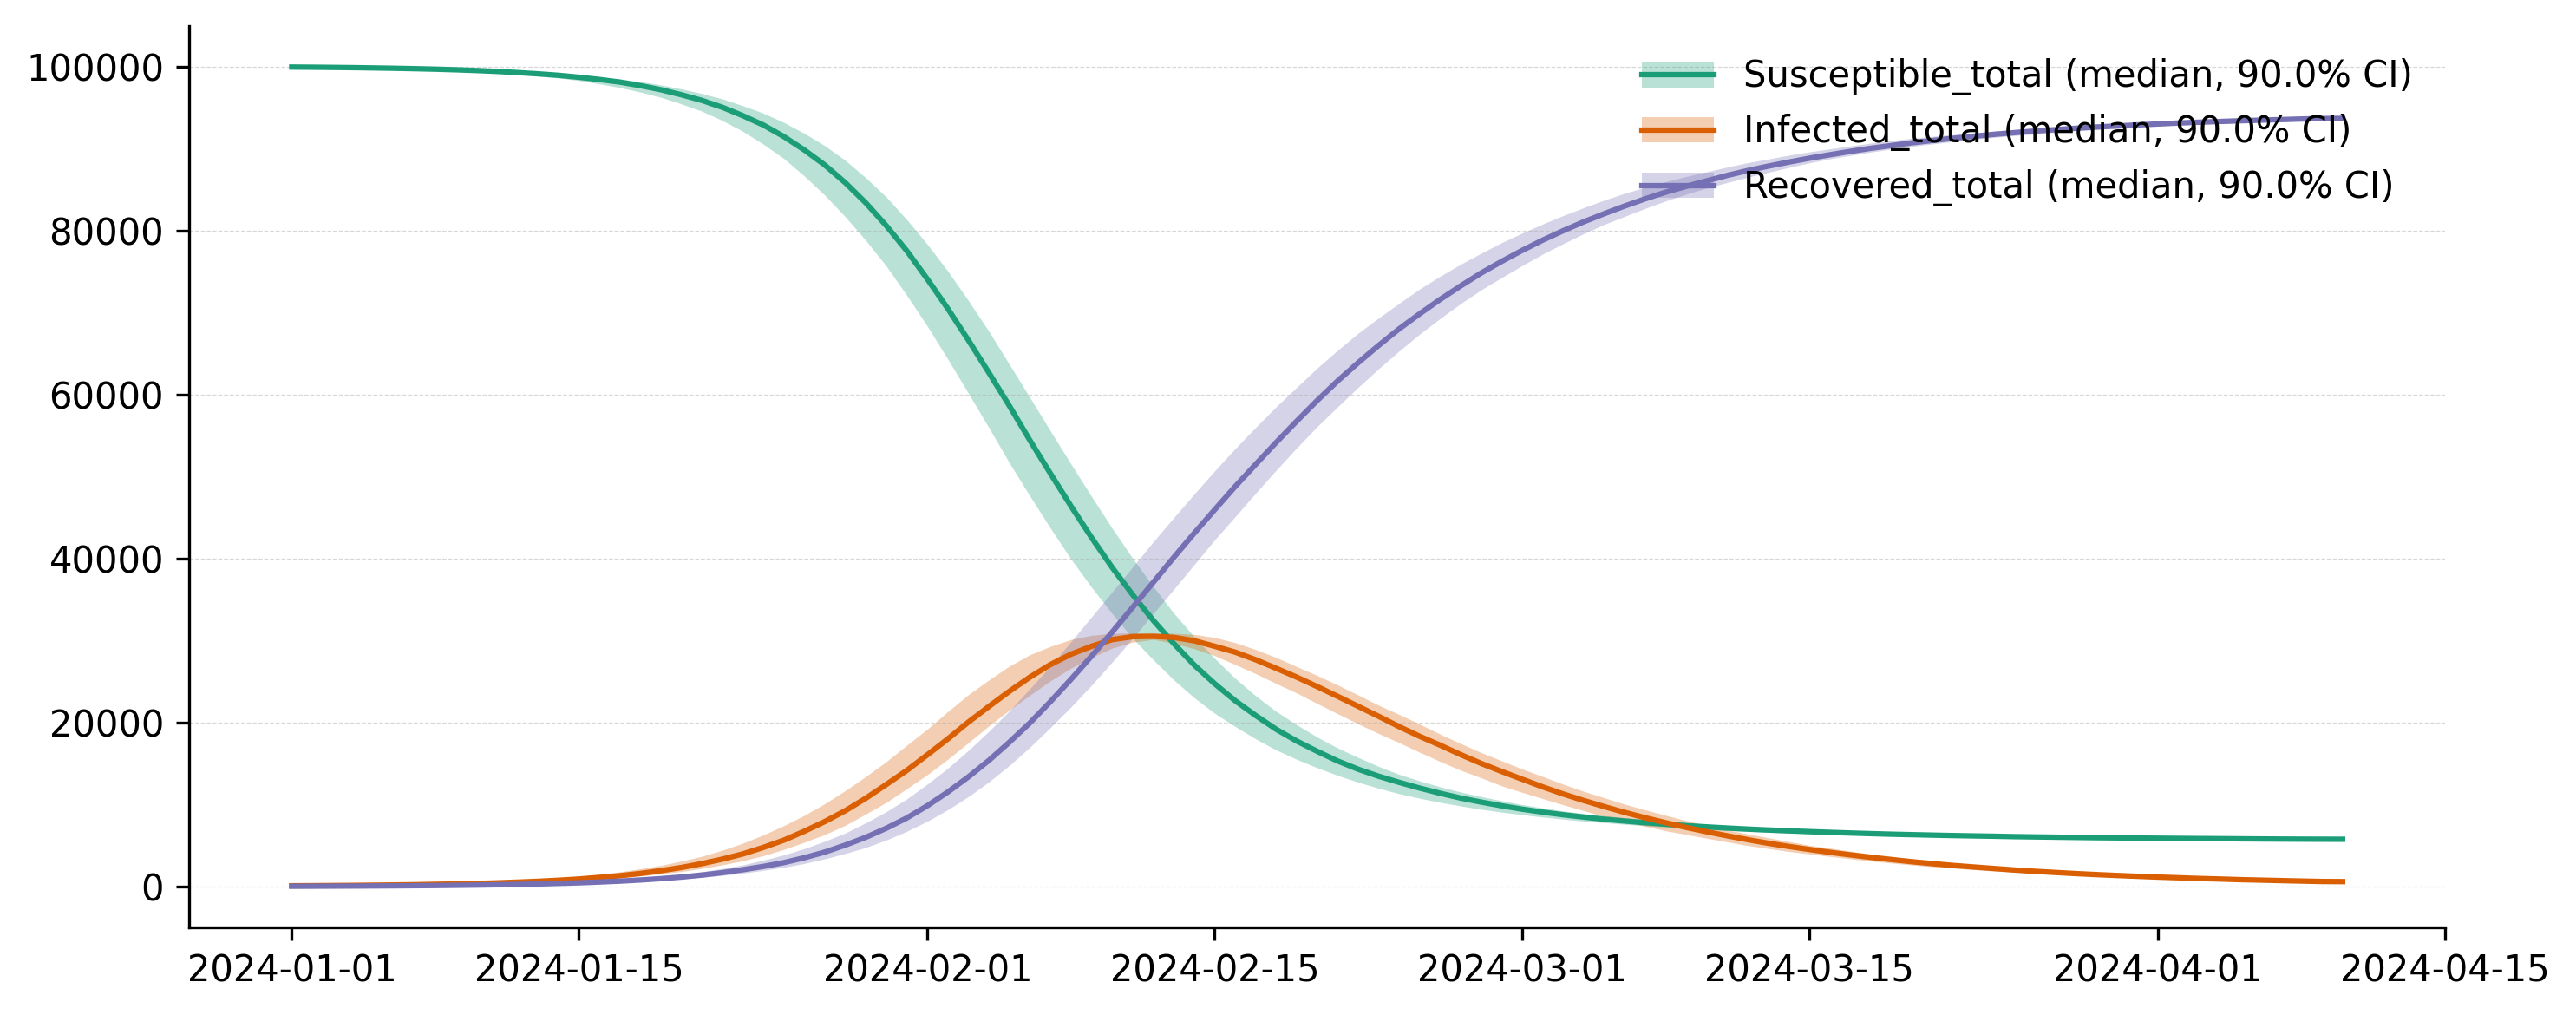

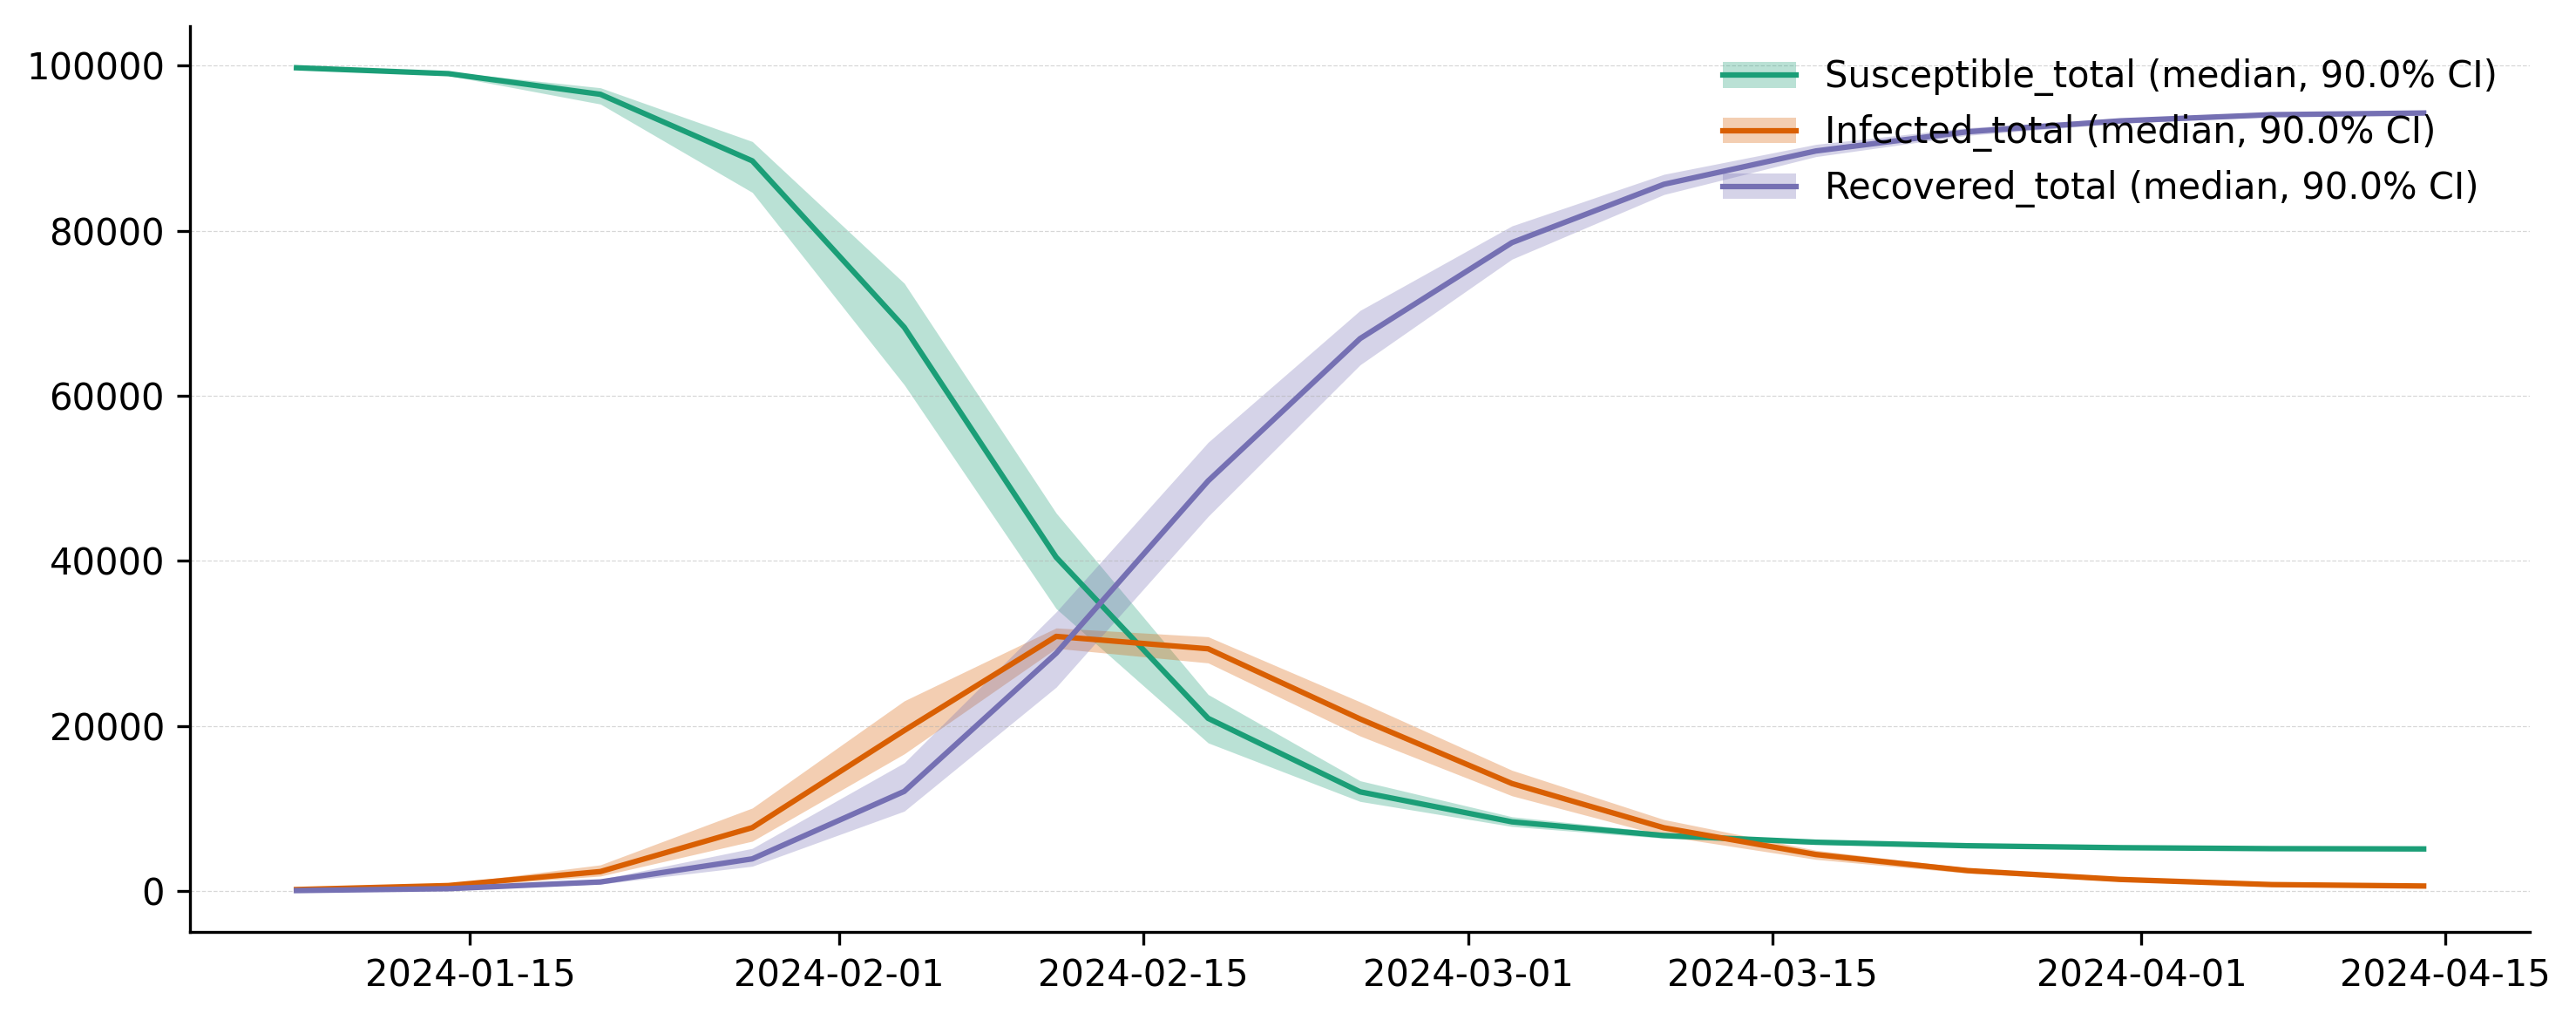

In [12]:
model = load_predefined_model("SIR")

# run the models with 1/3 day time steps (by default, the data is resampled at daily frequency)
results_shorter_dt = model.run_simulations(start_date=start_date, end_date=end_date, dt=1/3)

# run the models with 1 day time steps and 1 week resampling frequency
results_resampled = model.run_simulations(start_date=start_date, end_date=end_date, dt=1, resample_frequency="W")

# plot results
plot_quantiles(results_shorter_dt.get_quantiles_compartments(), columns=["Susceptible_total", "Infected_total", "Recovered_total"], legend_loc="upper right");
plot_quantiles(results_resampled.get_quantiles_compartments(), columns=["Susceptible_total", "Infected_total", "Recovered_total"], legend_loc="upper right");

By default, during resampling, compartments are aggregated taking the last value in the observation window (i.e. the $S$ individuals in the last day of the week). Transitions, are aggregated by summing the values in the observation window (i.e., submming all the individuals that transitioned in the week). This behavior can be changed by passing the `resample_aggregation_compartments` and `resample_aggregation_transitions` parameters to the `run_simulations` method.

Finally, it is possible to customize how NaN values are handled during the resampling step. NaN values can happen in cases where the resampling frequency is smaller than the simulation steps (i.e., simulation steps are daily, but resampling is done hourly). By default, NaN values are filled with the last available value. This behavior can be changed by passing the `fill_method` parameter to the `run_simulations` method.



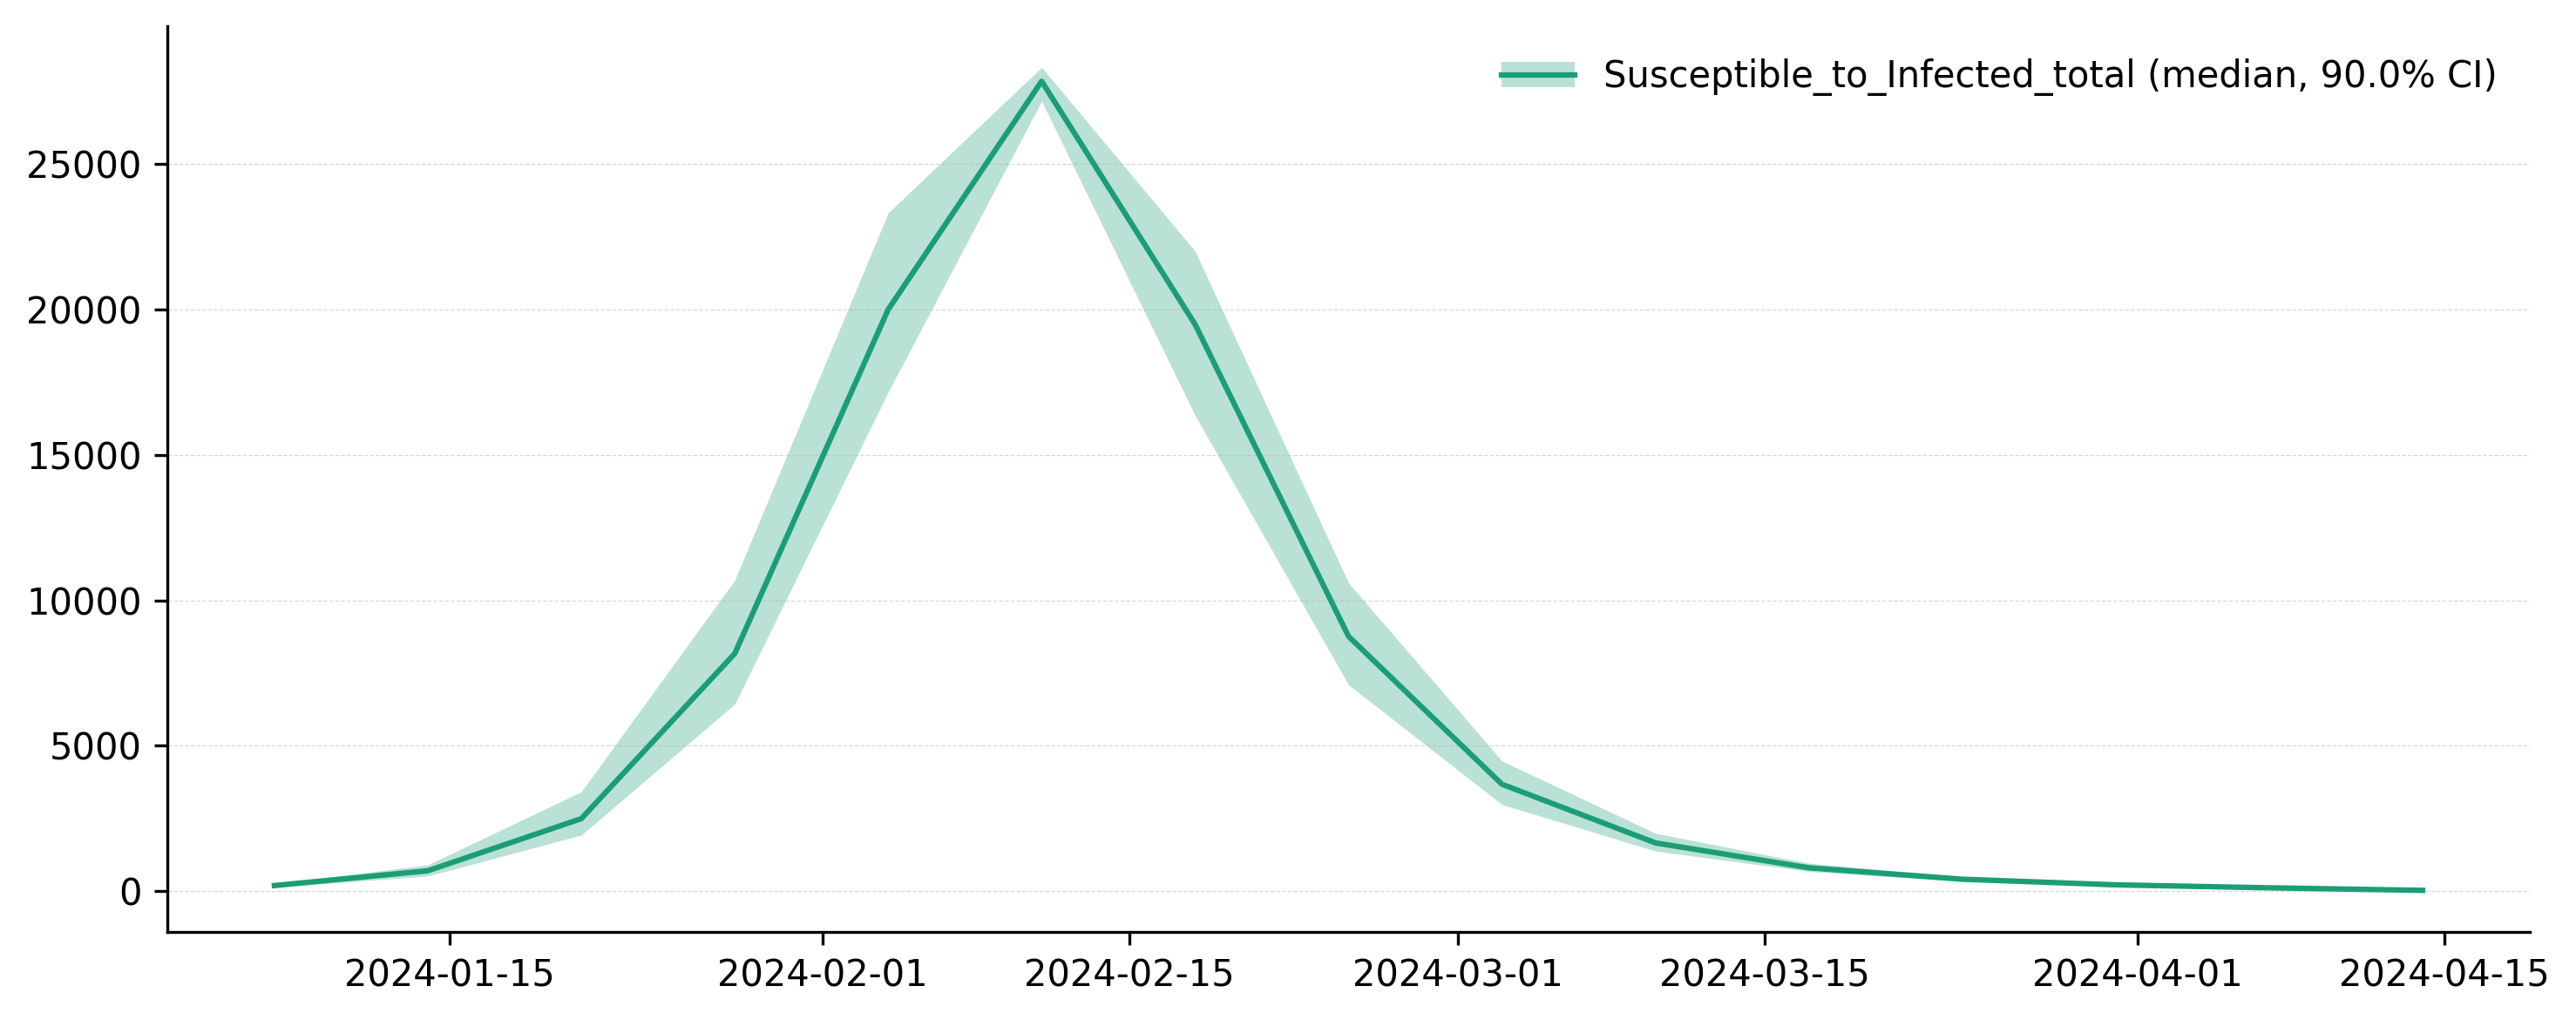

In [13]:
# plot total weekly new infections
plot_quantiles(results_resampled.get_quantiles_transitions(), columns=["Susceptible_to_Infected_total"], legend_loc="upper right");

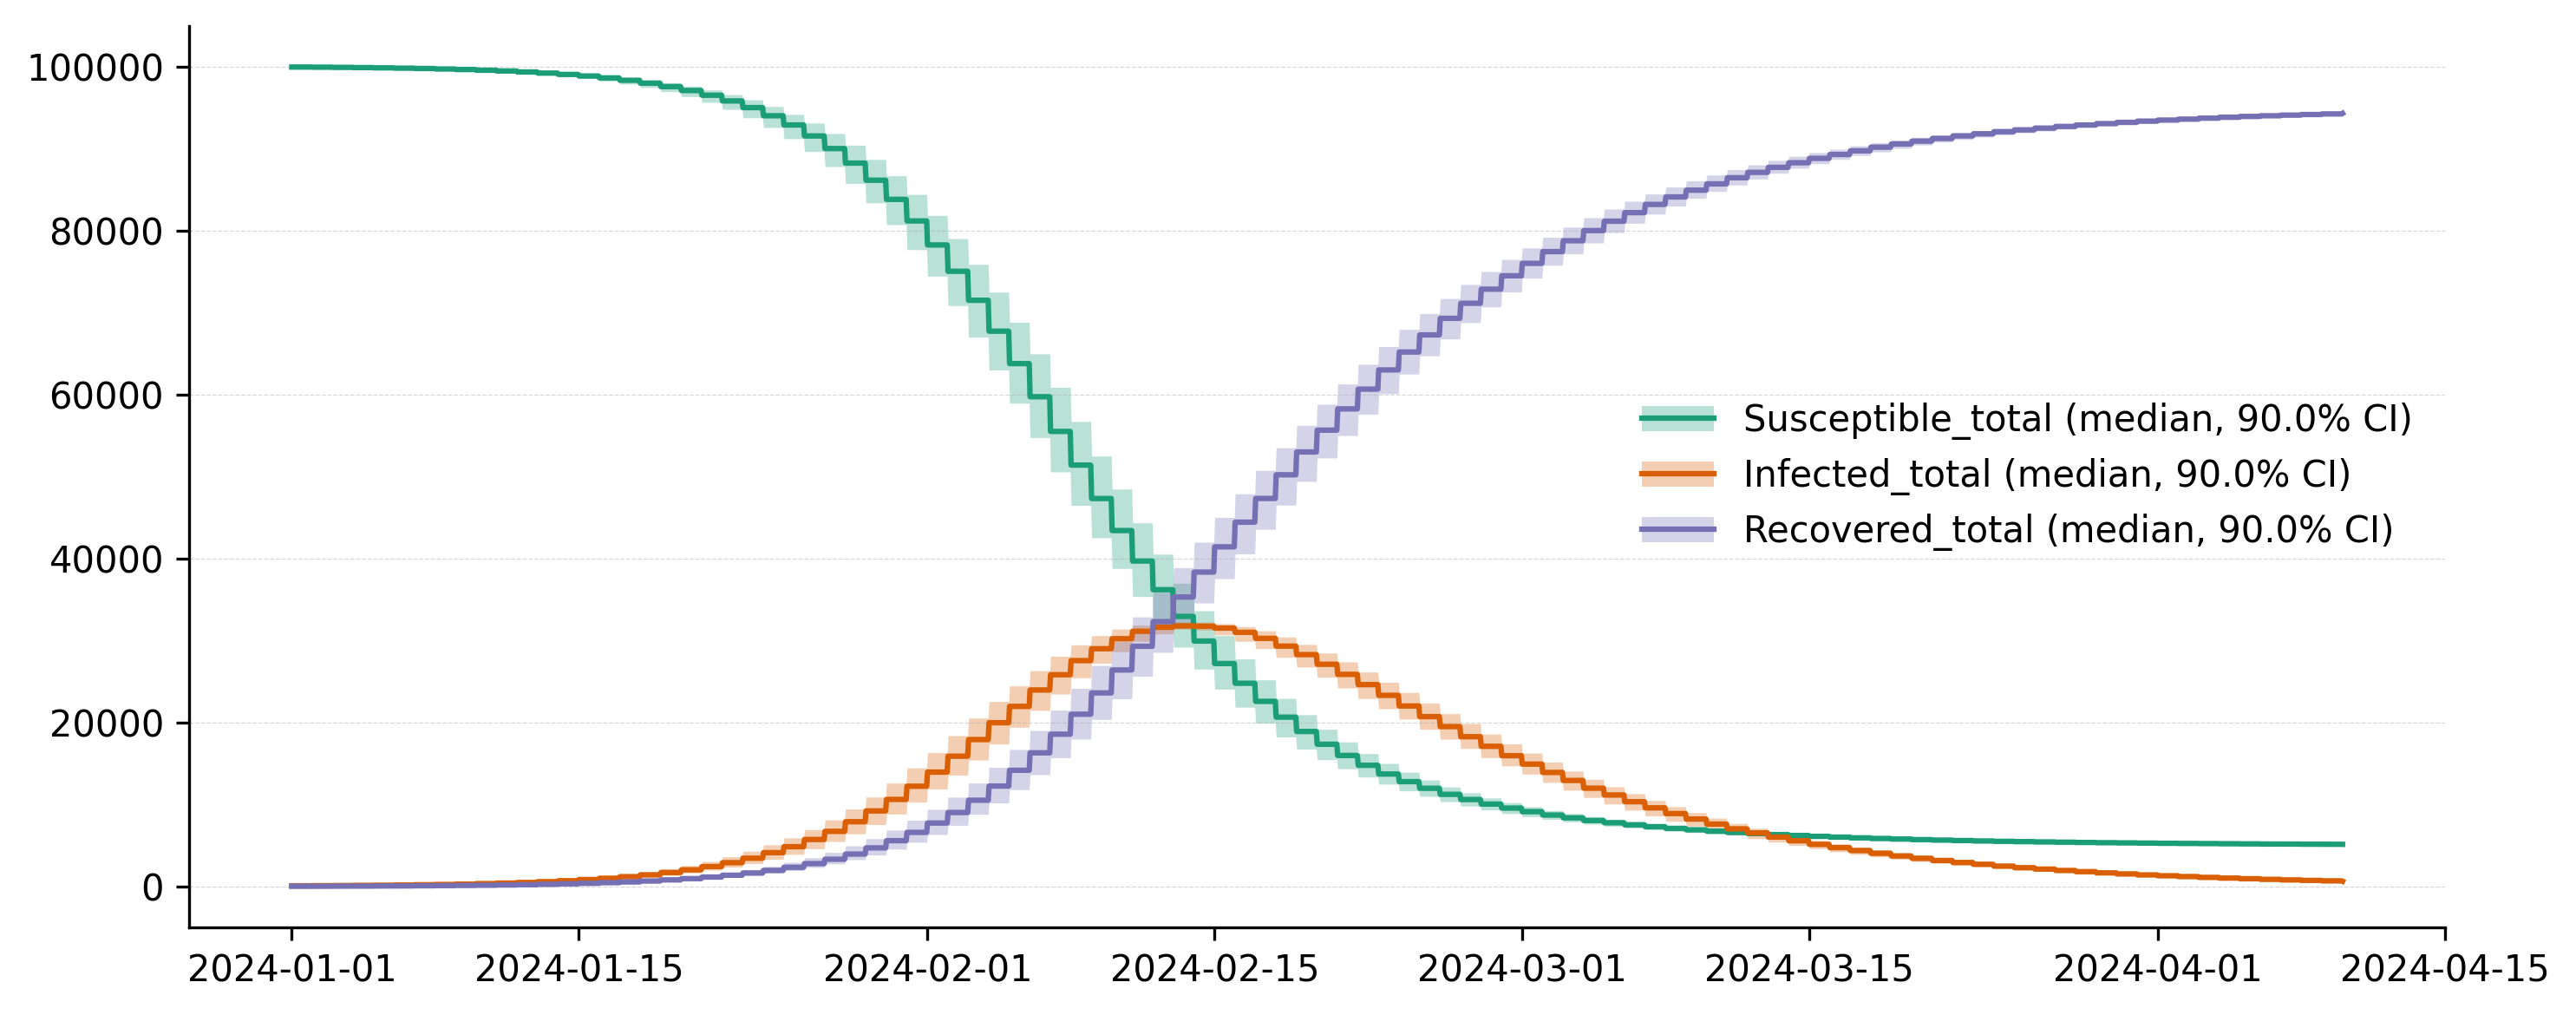

In [14]:
# run the models with 1 day time steps but resample hourly
results_resampled = model.run_simulations(start_date=start_date, end_date=end_date, dt=1, resample_frequency="1h")
plot_quantiles(results_resampled.get_quantiles_compartments(), columns=["Susceptible_total", "Infected_total", "Recovered_total"], legend_loc="center right");